# Train, tune, and deploy a custom ML model using the Time Series Classification (CNN-SVM) Algorithm from AWS Marketplace

The [Time Series Classification (CNN-SVM) Algorithm from AWS Marketplace](placeholder) 
performs time series classification with an unsupervised convolutional neural network followed by a support vector classifier. 
It implements both training and inference from CSV data and supports both CPU and GPU instances.
The training and inference Docker images were built by extending the PyTorch 2.0 Python 3.10 SageMaker containers.
The Docker images include modifications of software licensed under the Apache License 2.0, see the [LICENSE](https://github.com/fg-research/cnn-svc-sagemaker/blob/master/LICENSE) and [NOTICE](https://github.com/fg-research/cnn-svc-sagemaker/blob/master/NOTICE).

#### Model Overview  
The model has two components: an encoder which extracts the relevant features, 
and a support vector classifier which takes as input the extracted features and predicts the class labels.

The encoder includes a stack of exponentially dilated causal convolutional blocks, followed by an adaptive max pooling layer and a linear output layer.
Each block consists of two causal convolutional layers with the same dilation rate, each followed by weight normalization and Leaky ReLU activation.
A residual connection is applied between the input and the output of each block, where the input is transformed by an additional convolutional layer with a kernel size of 1 when its length does not match the one of the output.

The encoder parameters are learned in an unsupervised manner by minimizing the triplet loss.
The training procedure makes the extracted features of a given sequence (anchor) 
as close as possible to the extracted features of this same sequence's subsequences (positive samples) 
and as distant as possible from the extracted features of other subsequences (negative samples).

The number of features extracted by the encoder is determined by the number of hidden units of the linear output layer.
These features are used together with the class labels for training the support vector classifier. 

<img src=https://fg-research-assets.s3.eu-west-1.amazonaws.com/cnn-encoder-diagram.png style="width:80%;margin-top:30px;margin-bottom:20px"/>

*Encoder architecture (source: [doi.org/10.48550/arXiv.1901.10738](https://doi.org/10.48550/arXiv.1901.10738))*

#### Model Resources 
- **Paper:** [Unsupervised scalable representation learning for multivariate time series](https://doi.org/10.48550/arXiv.1901.10738).

This sample notebook shows you how to train a custom ML model using the [Time Series Classification (CNN-SVM) Algorithm from AWS Marketplace](placeholder).

**Note: This is a reference notebook and it cannot run unless you make the changes suggested in the notebook.**

## Pre-requisites
1. This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to the [Time Series Classification (CNN-SVM) Algorithm from AWS Marketplace](placeholder).

## Contents
1. [Subscribe to the algorithm](#1.-Subscribe-to-the-algorithm)
1. [Prepare dataset](#2.-Prepare-dataset)
	1. [Dataset format expected by the algorithm](#A.-Dataset-format-expected-by-the-algorithm)
	1. [Configure and visualize train and test dataset](#B.-Configure-and-visualize-train-and-test-dataset)
	1. [Upload datasets to Amazon S3](#C.-Upload-datasets-to-Amazon-S3)
1. [Train a machine learning model](#3:-Train-a-machine-learning-model)
	1. [Set up environment](#3.1-Set-up-environment)
	1. [Train a model](#3.2-Train-a-model)
1. [Deploy model and verify results](#4:-Deploy-model-and-verify-results)
    1. [Deploy trained model](#A.-Deploy-trained-model)
    1. [Create input payload](#B.-Create-input-payload)
    1. [Perform real-time inference](#C.-Perform-real-time-inference)
    1. [Visualize output](#D.-Visualize-output)
    1. [Calculate relevant metrics](#E.-Calculate-relevant-metrics)
    1. [Delete the endpoint](#F.-Delete-the-endpoint)
1. [Tune your model! (optional)](#5:-Tune-your-model!-(optional))
	1. [Tuning Guidelines](#A.-Tuning-Guidelines)
	1. [Define Tuning configuration](#B.-Define-Tuning-configuration)
	1. [Run a model tuning job](#C.-Run-a-model-tuning-job)
1. [Perform Batch inference](#6.-Perform-Batch-inference)
1. [Clean-up](#7.-Clean-up)
	1. [Delete the model](#A.-Delete-the-model)
	1. [Unsubscribe to the listing (optional)](#B.-Unsubscribe-to-the-listing-(optional))


## Usage instructions
You can run this notebook one cell at a time (by using Shift+Enter for running a cell).

## 1. Subscribe to the algorithm

To subscribe to the algorithm:
1. Open the algorithm listing page.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on the **Continue to configuration** button and then choose a **region**, you will see a **Product ARN**. This is the algorithm ARN that you need to specify while training a custom ML model. **Copy the ARN corresponding to your region and specify the same in the following cell.**

In [1]:
algo_arn = "arn:aws:sagemaker:eu-west-1:661670223746:algorithm/cnn-svc-algo-v1-1"

## 2. Prepare dataset

In [2]:
import io
import datetime
import boto3
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [3]:
# S3 bucket
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
bucket

'sagemaker-eu-west-1-661670223746'

In [4]:
# EC2 instance
instance_type = "ml.m5.2xlarge"

### A. Dataset format expected by the algorithm

The training (and optionally, validation) dataset should be provided as a CSV file. 
The CSV file should not contain any index column or column headers. 
Each row of the CSV file represents a time series, while each column represents a time step.
The class labels should be stored in the first column, while the time series should be stored in the subsequent columns.
The time series can have different lengths and can contain missing values.
The time series are scaled internally by the algorithm, there is no need to scale the time series beforehand.

You can find more information about dataset format in the **Usage Information** section of the algorithm listing page.

### B. Configure and visualize train and test dataset

The sample data provided in the algorithm's [GitHub repository](https://github.com/fg-research/cnn-svc-sagemaker) consists of three classes of artificially generated time series. The length of each time series is 50 time steps. The training dataset contains 160 time series, while the validation and test datasets contain 100 time series.

**Training dataset:**

In [5]:
training_dataset = pd.read_csv(
    "https://raw.githubusercontent.com/fg-research/cnn-svc-sagemaker/master/data/training/train.csv",
    header=None,
    index_col=None
)

In [6]:
training_dataset.shape

(160, 51)

In [7]:
training_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,-0.797585,2.015231,12.426042,NaN,26.493112,38.159786,40.466293,38.075383,25.850376,...,23.001525,30.220322,37.840861,41.102358,38.377708,30.820642,19.199454,6.955922,3.554906,-1.670007
1,2.0,-2.316543,-19.907201,-6.582620,18.726430,47.665109,56.184751,34.659966,17.741448,11.521070,...,25.168604,49.202017,59.746818,37.288141,24.909200,NaN,NaN,NaN,NaN,NaN
2,1.0,19.879468,1.034652,2.002918,21.309871,35.672321,38.774849,20.410609,3.322058,-0.438325,...,22.336948,37.707969,38.714832,18.072289,1.328104,1.046517,24.852571,36.874760,37.457698,19.278949
3,1.0,17.377493,1.788119,1.596060,19.829005,37.144964,38.941167,26.985154,6.164213,-0.793006,...,26.791420,38.308387,34.270954,19.145544,0.303361,2.943842,20.928491,34.711154,38.872772,23.446747
4,1.0,21.649950,4.178282,0.173992,22.041793,34.671454,38.610631,27.262495,5.349270,3.558867,...,19.718359,39.542590,35.723505,16.157116,5.168295,0.320677,27.509420,39.633493,37.857850,14.985378


In [8]:
training_dataset.iloc[:, 0].sort_values().unique()

array([0., 1., 2.])

In [9]:
training_dataset.iloc[:, 0].rename(None).value_counts().sort_index()

0.0    54
1.0    53
2.0    53
Name: count, dtype: int64

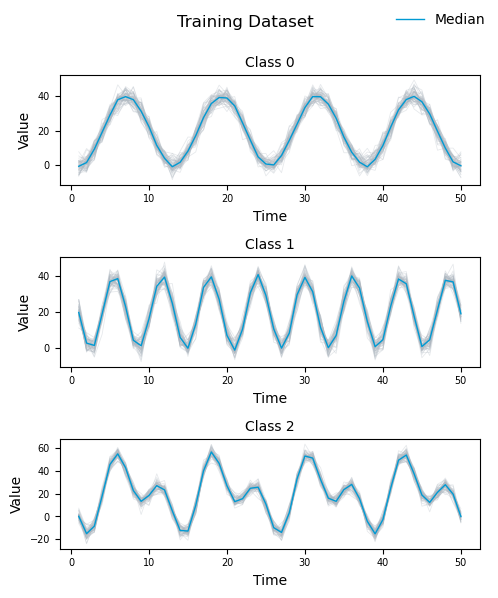

In [10]:
fig, axs = plt.subplots(nrows=training_dataset.iloc[:, 0].nunique(), ncols=1, sharex=True, figsize=(5, 6))
for i, c in enumerate(training_dataset.iloc[:, 0].sort_values().unique()):
    axs[i].plot(training_dataset[training_dataset.iloc[:, 0] == c].iloc[:, 1:].transpose(), color="#AFB8C1", lw=0.6, alpha=0.3)
    axs[i].plot(training_dataset[training_dataset.iloc[:, 0] == c].iloc[:, 1:].transpose().median(axis=1), color="#009ad3", lw=1, label="Median" if i == 0 else None)
    axs[i].set_title(f"Class {int(c)}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Training Dataset")
fig.legend(frameon=False)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.show()

**Validation dataset:**

In [11]:
validation_dataset = pd.read_csv(
    "https://raw.githubusercontent.com/fg-research/cnn-svc-sagemaker/master/data/training/valid.csv",
    header=None,
    index_col=None
)

In [12]:
validation_dataset.shape

(100, 51)

In [13]:
validation_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,1.0,20.295466,5.223107,1.169853,18.653988,35.608982,NaN,22.162075,-4.576533,-0.325949,...,27.543584,38.034239,31.775313,15.547546,0.957798,8.482505,19.702106,31.063984,40.382783,17.037570
1,0.0,5.341879,2.766792,12.006425,18.327912,21.931373,39.353907,38.489319,42.215769,31.874020,...,24.209602,30.327661,38.814551,43.067362,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,2.927144,-12.435267,-12.184122,18.613749,46.504512,54.305264,42.224062,25.753400,6.655210,...,21.113072,45.599227,58.108288,37.987212,15.630178,9.572159,25.071954,32.052373,18.117028,-0.608891
3,0.0,3.886493,0.811233,12.632547,17.486188,28.484575,31.559220,40.087728,43.772191,31.701915,...,19.931390,33.053971,36.314061,42.515570,35.776251,31.828678,18.003085,5.619873,5.799750,0.490593
4,1.0,23.075897,3.579315,4.754499,23.445945,38.159160,40.313405,21.371599,4.089839,-5.001989,...,21.240097,40.296813,36.719782,17.961007,2.382493,4.782322,21.582301,34.471528,40.196193,18.567845


In [14]:
validation_dataset.iloc[:, 0].sort_values().unique()

array([0., 1., 2.])

In [15]:
validation_dataset.iloc[:, 0].rename(None).value_counts().sort_index()

0.0    33
1.0    34
2.0    33
Name: count, dtype: int64

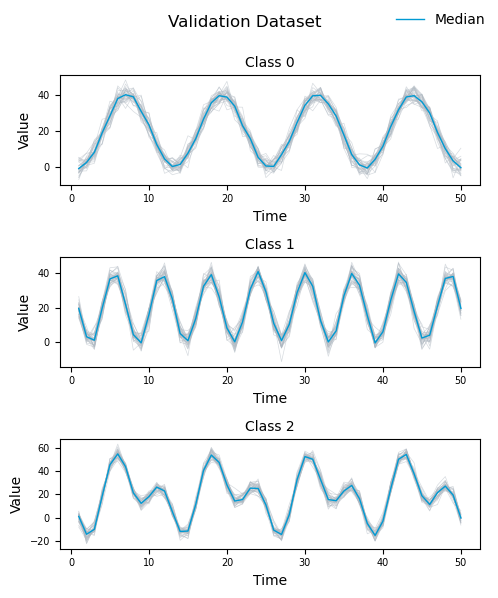

In [16]:
fig, axs = plt.subplots(nrows=validation_dataset.iloc[:, 0].nunique(), ncols=1, sharex=True, figsize=(5, 6))
for i, c in enumerate(validation_dataset.iloc[:, 0].sort_values().unique()):
    axs[i].plot(validation_dataset[validation_dataset.iloc[:, 0] == c].iloc[:, 1:].transpose(), color="#AFB8C1", lw=0.5, alpha=0.5)
    axs[i].plot(validation_dataset[validation_dataset.iloc[:, 0] == c].iloc[:, 1:].transpose().median(axis=1), color="#009ad3", lw=1, label="Median" if i == 0 else None)
    axs[i].set_title(f"Class {int(c)}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.subplots_adjust(hspace=0.75)
fig.suptitle("Validation Dataset")
fig.legend(frameon=False)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.show()

### C. Upload datasets to Amazon S3

In [17]:
training_data = sagemaker_session.upload_string_as_file_body(
    body=training_dataset.to_csv(index=False, header=False),
    bucket=bucket,
    key="data/training/train.csv"
)

In [18]:
training_data

's3://sagemaker-eu-west-1-661670223746/data/training/train.csv'

In [19]:
validation_data = sagemaker_session.upload_string_as_file_body(
    body=validation_dataset.to_csv(index=False, header=False),
    bucket=bucket,
    key="data/training/valid.csv"
)

In [20]:
validation_data

's3://sagemaker-eu-west-1-661670223746/data/training/valid.csv'

## 3: Train a machine learning model

Now that dataset is available in an accessible Amazon S3 bucket, we are ready to train a machine learning model. 

### 3.1 Set up environment

In [21]:
role = sagemaker.get_execution_role()

### 3.2 Train a model

You can find more information about the model's hyperparameters in the **Hyperparameters** section of the algorithm listing page.

In [22]:
# define hyperparameters
hyperparameters = {
    "penalty": 0.1,
    "kernel": "rbf",
    "blocks": 2,
    "filters": 16,
    "kernel-size": 3,
    "reduced-size": 10,
    "output-size": 20,
    "negative-samples": 10,
    "lr": 0.001,
    "batch-size": 64,
    "epochs": 100,
}

For information on creating an `Estimator` object, see the [documentation](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html).

In [23]:
# create an estimator object for running a training job
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    base_job_name="cnn-svc-training",
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters=hyperparameters,
)

In [24]:
# run the training job
estimator.fit({"training": training_data, "validation": validation_data})

INFO:sagemaker:Creating training-job with name: cnn-svc-training-2023-08-13-17-11-13-054


2023-08-13 17:11:13 Starting - Starting the training job...
2023-08-13 17:11:28 Starting - Preparing the instances for training......
2023-08-13 17:12:17 Downloading - Downloading input data...
2023-08-13 17:12:57 Training - Downloading the training image...............
2023-08-13 17:15:43 Training - Training image download completed. Training in progress.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-08-13 17:16:11,717 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-08-13 17:16:11,718 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-08-13 17:16:11,718 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-08-13 17:16:11,718 sagemaker-training-toolkit INFO     Failed to parse hyperparameter kernel value rbf to Json.
Returning the value itself
2023-08-13 17:16:11,727 sagemaker_pytorch_cont

See this [blog-post](https://aws.amazon.com/blogs/machine-learning/easily-monitor-and-visualize-metrics-while-training-models-on-amazon-sagemaker/) for more information how to visualize metrics during the process. You can also open the training job from [Amazon SageMaker console](https://console.aws.amazon.com/sagemaker/home?#/jobs/) and monitor the metrics/logs in **Monitor** section.

## 4: Deploy model and verify results

Now you can deploy the model for performing real-time inference.

### A. Deploy trained model

In [25]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    serializer=sagemaker.serializers.CSVSerializer(content_type="text/csv"),
    model_name=f"cnn-svc-model-{datetime.datetime.now().strftime(format='%Y-%m-%d-%H-%M-%S-%f')}",
    endpoint_name=f"cnn-svc-endpoint-{datetime.datetime.now().strftime(format='%Y-%m-%d-%H-%M-%S-%f')}",
)

INFO:sagemaker:Creating model package with name: cnn-svc-model-2023-08-13-17-25-18-986485


.........

INFO:sagemaker:Creating model with name: cnn-svc-model-2023-08-13-17-25-18-986485


INFO:sagemaker:Creating endpoint-config with name cnn-svc-endpoint-2023-08-13-17-25-18-986508
INFO:sagemaker:Creating endpoint with name cnn-svc-endpoint-2023-08-13-17-25-18-986508


-------!

Once the endpoint is in service, you can perform real-time inference.

### B. Create input payload

The inference algorithm takes as input a CSV file containing the time series.
The CSV file should not contain any index column or column headers.
Each row of the CSV file represents a time series, while each column represents a time step.
The time series can have different lengths and can contain missing values.
The time series are scaled internally by the algorithm, there is no need to scale the time series beforehand.

**Test dataset:**

In [26]:
test_dataset = pd.read_csv(
    "https://raw.githubusercontent.com/fg-research/cnn-svc-sagemaker/master/data/inference/input/test_data.csv",
    header=None,
    index_col=None
)

In [27]:
test_dataset.shape

(100, 50)

In [28]:
test_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.961892,NaN,3.339272,15.918861,23.148579,37.920989,42.657312,39.429838,33.690162,22.605304,...,24.048562,32.525504,41.402378,42.836975,41.496963,27.778819,18.709208,10.120667,1.238937,2.138014
1,-4.938655,-12.823784,-7.292687,20.669545,42.735701,55.915914,38.594117,22.359637,11.747328,18.839520,...,17.230889,52.348960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16.324562,-0.911984,0.084071,17.243492,34.250183,32.900130,24.934774,4.566914,-0.284355,13.901008,...,22.829803,36.337895,36.367390,17.925076,5.983147,2.227726,24.776385,39.280989,44.358031,27.447368
3,4.048841,3.631466,8.029529,21.408056,28.154454,39.698886,42.561894,37.829814,33.623053,23.585831,...,19.686609,30.887575,35.843583,35.373759,42.271459,32.067364,20.043963,12.015558,0.571687,-4.735478
4,19.125505,6.351013,4.143251,21.228201,41.127726,37.257361,20.231339,-1.873699,4.155265,10.903046,...,17.572881,41.220214,37.232189,16.771593,2.364200,0.014795,22.367995,37.847592,39.319366,18.939293


In [29]:
test_data = sagemaker_session.upload_string_as_file_body(
    body=test_dataset.to_csv(index=False, header=False),
    bucket=bucket,
    key="data/inference/input/test_data.csv"
)

In [30]:
test_data

's3://sagemaker-eu-west-1-661670223746/data/inference/input/test_data.csv'

In [31]:
payload = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix="data/inference/input/test_data.csv"
)

### C. Perform real-time inference

In [32]:
response = sagemaker_session.sagemaker_runtime_client.invoke_endpoint(
    EndpointName=predictor.endpoint_name,
    ContentType="text/csv",
    Body=payload
)

real_time_predictions = response["Body"].read().decode("utf-8").split("\n")[:-1]
real_time_predictions = pd.DataFrame(real_time_predictions).astype(float)

In [33]:
response

{'ResponseMetadata': {'RequestId': '835a33fd-126a-4df8-b8e7-5a08913f89d3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '835a33fd-126a-4df8-b8e7-5a08913f89d3',
   'x-amzn-invoked-production-variant': 'AllTraffic',
   'date': 'Sun, 13 Aug 2023 17:30:07 GMT',
   'content-type': 'application/json',
   'content-length': '400',
   'connection': 'keep-alive'},
  'RetryAttempts': 0},
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'AllTraffic',
 'Body': <botocore.response.StreamingBody at 0x7f8841843e80>}

In [34]:
real_time_results = sagemaker_session.upload_string_as_file_body(
    body=real_time_predictions.to_csv(index=False, header=False),
    bucket=bucket, 
    key="data/inference/output/real-time/real_time_predictions.csv"
)

In [35]:
real_time_results

's3://sagemaker-eu-west-1-661670223746/data/inference/output/real-time/real_time_predictions.csv'

### D. Visualize output

The inference algorithm outputs the predicted class labels, which are returned in CSV format.

In [36]:
real_time_predictions.shape

(100, 1)

In [37]:
real_time_predictions.head()

,0
0,0.0
1,2.0
2,0.0
3,0.0
4,1.0


In [38]:
real_time_predictions.iloc[:, 0].sort_values().unique()

array([0., 1., 2.])

In [39]:
real_time_predictions.iloc[:, 0].rename(None).value_counts().sort_index()

0.0    34
1.0    32
2.0    34
Name: count, dtype: int64

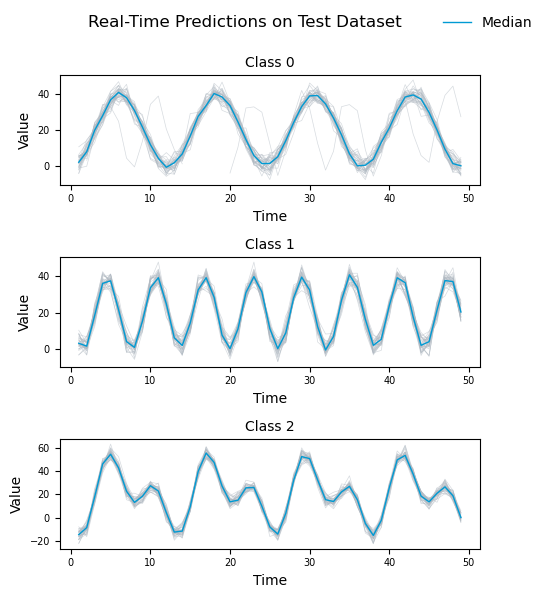

In [40]:
fig, axs = plt.subplots(nrows=real_time_predictions.iloc[:, 0].nunique(), ncols=1, sharex=True, figsize=(5, 6))
for i, c in enumerate(real_time_predictions.iloc[:, 0].sort_values().unique()):
    axs[i].plot(test_dataset[real_time_predictions.iloc[:, 0] == c].iloc[:, 1:].transpose(), color="#AFB8C1", lw=0.5, alpha=0.5)
    axs[i].plot(test_dataset[real_time_predictions.iloc[:, 0] == c].iloc[:, 1:].transpose().median(axis=1), color="#009ad3", lw=1, label="Median" if i == 0 else None)
    axs[i].set_title(f"Class {int(c)}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.subplots_adjust(hspace=0.75)
fig.suptitle("Real-Time Predictions on Test Dataset")
fig.legend(frameon=False, bbox_to_anchor=(0, 0, 1.1, 1))
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.show()

### E. Calculate relevant metrics

In this section we assess the model's classification performance against the ground truth test labels. We use `scikit-learn`'s [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) for calculating the main classification metrics for each class. 

In [41]:
test_labels = pd.read_csv(
    "https://raw.githubusercontent.com/fg-research/cnn-svc-sagemaker/master/data/inference/output/test_labels.csv",
    header=None,
    index_col=None
)

In [42]:
test_labels.shape

(100, 1)

In [43]:
test_labels.head()

,0
0,0.0
1,2.0
2,1.0
3,0.0
4,1.0


In [44]:
test_labels.iloc[:, 0].sort_values().unique()

array([0., 1., 2.])

In [45]:
test_labels.iloc[:, 0].rename(None).value_counts().sort_index()

0.0    33
1.0    33
2.0    34
Name: count, dtype: int64

In [46]:
metrics = pd.DataFrame(classification_report(y_true=test_labels.iloc[:, 0], y_pred=real_time_predictions.iloc[:, 0], output_dict=True))

In [47]:
metrics

,0.0,1.0,2.0,accuracy,macro avg,weighted avg
precision,0.970588,1.000000,1.0,0.99,0.990196,0.990294
recall,1.000000,0.969697,1.0,0.99,0.989899,0.990000
f1-score,0.985075,0.984615,1.0,0.99,0.989897,0.989998
support,33.000000,33.000000,34.0,0.99,100.000000,100.000000


If [Amazon SageMaker Model Monitor](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html) supports the type of problem you are trying to solve using this algorithm, use the following examples to add Model Monitor support to your product.
For sample code to enable and monitor the model, see following notebooks:
1. [Enable Amazon SageMaker Model Monitor](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker_model_monitor/enable_model_monitor/SageMaker-Enable-Model-Monitor.ipynb)
2. [Amazon SageMaker Model Monitor - visualizing monitoring results](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker_model_monitor/visualization/SageMaker-Model-Monitor-Visualize.ipynb)

### F. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the same to avoid being charged.

In [48]:
predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: cnn-svc-endpoint-2023-08-13-17-25-18-986508
INFO:sagemaker:Deleting endpoint with name: cnn-svc-endpoint-2023-08-13-17-25-18-986508


Since this is an experiment, you do not need to run a hyperparameter tuning job. However, if you would like to see how to tune a model trained using a third-party algorithm with Amazon SageMaker's hyperparameter tuning functionality, you can run the optional tuning step.

## 5: Tune your model! (optional)

### A. Tuning Guidelines

The model has the following hyperparameters, all of which are tunable:
- `penalty`: `float`. The regularization parameter of the support vector classifier	(default = 0).
- `kernel`: `str`. The kernel function of the support vector classifier	(default = "rbf").
- `blocks`: `int`. The number of blocks of convolutional layers	(default = 10).
- `filters`: `int`.	The number of filters of all but the last convolutional layers (default = 40).
- `kernel-size`: `int`.	The size of the kernel of all non-residual convolutional layers (default = 3).	
- `reduced-size`: `int`. The number of filters of the last convolutional layer (default = 160).	
- `output-size`: `int`.	The number of hidden units of the linear output layer (default = 320).
- `negative-samples`: `int`. The number of negative samples used for calculating the triplet loss (default = 10).
- `lr`: `float`. The learning rate used for training (default = 0.001).
- `batch-size`: `int`. The batch size used for training (default = 10).
- `epochs`: `int`. The number of training epochs (default = 100).

### B. Define Tuning configuration

In [49]:
hyperparameter_ranges = {
    "penalty": sagemaker.parameter.ContinuousParameter(0, 1),
    "kernel": sagemaker.parameter.CategoricalParameter(["rbf", "linear", "sigmoid", "poly"]),
    "blocks": sagemaker.parameter.IntegerParameter(1, 10),
    "filters": sagemaker.parameter.IntegerParameter(4, 40),
    "kernel-size": sagemaker.parameter.CategoricalParameter([3, 5, 7]),
    "reduced-size": sagemaker.parameter.IntegerParameter(10, 20),
    "output-size": sagemaker.parameter.IntegerParameter(20, 40),
    "negative-samples": sagemaker.parameter.CategoricalParameter([1, 5, 10]),
    "lr": sagemaker.parameter.ContinuousParameter(0.0001, 0.01),
    "batch-size": sagemaker.parameter.CategoricalParameter([64, 128]),
    "epochs": sagemaker.parameter.CategoricalParameter([100, 200]),
}

We use the validation accuracy as the objective to be maximized.

In [50]:
objective_metric_name = "valid_accuracy"

In [51]:
objective_type = "Maximize"

### C. Run a model tuning job

In the interest of time, we run the tuner only for a few iterations. 

In [52]:
tuner = sagemaker.tuner.HyperparameterTuner(
    estimator=estimator,
    base_tuning_job_name="cnn-svc-tuning",
    objective_metric_name=objective_metric_name,
    objective_type=objective_type,
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=8,
    max_parallel_jobs=8,
    random_seed=0,
)

In [53]:
tuner.fit({"training": training_data, "validation": validation_data})

INFO:sagemaker:Creating hyperparameter tuning job with name: cnn-svc-tuning-230813-1730


...................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [54]:
tuner.analytics().dataframe().sort_values(by="FinalObjectiveValue", ascending=False, ignore_index=True)

,batch-size,blocks,epochs,filters,kernel,kernel-size,lr,negative-samples,output-size,penalty,reduced-size,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,128.0,3.0,200.0,22.0,rbf,7.0,0.002576,5.0,28.0,0.195591,20.0,cnn-svc-tuning-230813-1730-006-fee6f6f8,Completed,1.00,2023-08-13 17:31:24+00:00,2023-08-13 17:51:30+00:00,1206.0
1,64.0,6.0,100.0,25.0,linear,5.0,0.000450,10.0,40.0,0.601620,14.0,cnn-svc-tuning-230813-1730-003-647b644c,Completed,0.98,2023-08-13 17:31:28+00:00,2023-08-13 18:02:42+00:00,1874.0
2,64.0,7.0,100.0,19.0,poly,3.0,0.000395,1.0,23.0,0.090827,14.0,cnn-svc-tuning-230813-1730-004-a8f39cd6,Completed,0.97,2023-08-13 17:31:24+00:00,2023-08-13 17:42:03+00:00,639.0
3,64.0,5.0,100.0,25.0,poly,3.0,0.007993,10.0,27.0,0.942624,19.0,cnn-svc-tuning-230813-1730-002-3d7b965f,Completed,0.97,2023-08-13 17:31:20+00:00,2023-08-13 17:54:12+00:00,1372.0
4,128.0,3.0,200.0,7.0,poly,5.0,0.004862,1.0,21.0,0.491501,15.0,cnn-svc-tuning-230813-1730-007-d3096aaf,Completed,0.96,2023-08-13 17:31:33+00:00,2023-08-13 17:41:47+00:00,614.0
5,64.0,3.0,100.0,24.0,sigmoid,3.0,0.000209,10.0,23.0,0.794160,15.0,cnn-svc-tuning-230813-1730-001-113a15db,Completed,0.95,2023-08-13 17:31:16+00:00,2023-08-13 17:47:16+00:00,960.0
6,64.0,9.0,100.0,8.0,poly,3.0,0.002512,5.0,29.0,0.516518,13.0,cnn-svc-tuning-230813-1730-005-b6bfd2c2,Completed,0.92,2023-08-13 17:31:28+00:00,2023-08-13 17:51:24+00:00,1196.0
7,128.0,8.0,100.0,8.0,sigmoid,7.0,0.000786,10.0,30.0,0.146805,16.0,cnn-svc-tuning-230813-1730-008-ca2e579e,Completed,0.64,2023-08-13 17:31:26+00:00,2023-08-13 18:04:51+00:00,2005.0


In [55]:
tuning_job_result = sagemaker_session.sagemaker_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.name
)

In [56]:
print("Best hyperparameters:")
tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]

Best hyperparameters:


{'batch-size': '128',
 'blocks': '3',
 'epochs': '200',
 'filters': '22',
 'kernel': 'rbf',
 'kernel-size': '7',
 'lr': '0.002576010911335757',
 'negative-samples': '5',
 'output-size': '28',
 'penalty': '0.19559081520180632',
 'reduced-size': '20'}

In [57]:
print("Best score:")
tuning_job_result["BestTrainingJob"]["FinalHyperParameterTuningJobObjectiveMetric"]["Value"]

Best score:


1.0

Once you have completed a tuning job (or even while the job is still running), you can [clone and use this notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/hyperparameter_tuning/analyze_results/HPO_Analyze_TuningJob_Results.ipynb) to analyze the results to understand how each hyperparameter effects the quality of the model.

## 6. Perform Batch inference

In this section, you will perform batch inference.

In [58]:
transformer = estimator.transformer(
    instance_count=1,
    instance_type=instance_type,
)

INFO:sagemaker:Creating model package with name: cnn-svc-algo-v1-1-2023-08-13-18-05-55-693


.........

INFO:sagemaker:Creating model with name: cnn-svc-algo-v1-1-2023-08-13-18-05-55-6-2023-08-13-18-06-41-117


In [59]:
transformer.base_transform_job_name = "cnn-svc-transform"

In [60]:
transformer.transform(
    data=test_data,
    content_type="text/csv",
)

INFO:sagemaker:Creating transform job with name: cnn-svc-transform-2023-08-13-18-06-41-933


2023-08-13T18:13:30,747 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2023-08-13T18:13:30,804 [INFO ] main org.pytorch.serve.metrics.configuration.MetricConfiguration - Successfully loaded metrics configuration from /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
2023-08-13T18:13:30,899 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.8.1
TS Home: /opt/conda/lib/python3.10/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Metrics config path: /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
Number of GPUs: 0
Number of CPUs: 8
Max heap size: 7840 M
Python executable: /opt/conda/bin/python3.10
Config file: /etc/sagemaker-ts.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.0:8080
Metrics address: http://127.0.0.1:8082
Model Store: /.sagemaker/ts/models
Initial Models: model=/opt/ml/model
2023-08-13T18:13:30,747 [INFO ] main org.pytor

In [61]:
batch_predictions = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix=f"{transformer.latest_transform_job.name}/test_data.csv.out"
)

batch_predictions = batch_predictions.split("\n")[:-1]
batch_predictions = pd.DataFrame(batch_predictions).astype(float)

In [62]:
batch_predictions.shape

(100, 1)

In [63]:
batch_predictions.head()

,0
0,0.0
1,2.0
2,0.0
3,0.0
4,1.0


In [64]:
batch_predictions.iloc[:, 0].sort_values().unique()

array([0., 1., 2.])

In [65]:
batch_predictions.iloc[:, 0].rename(None).value_counts().sort_index()

0.0    34
1.0    32
2.0    34
Name: count, dtype: int64

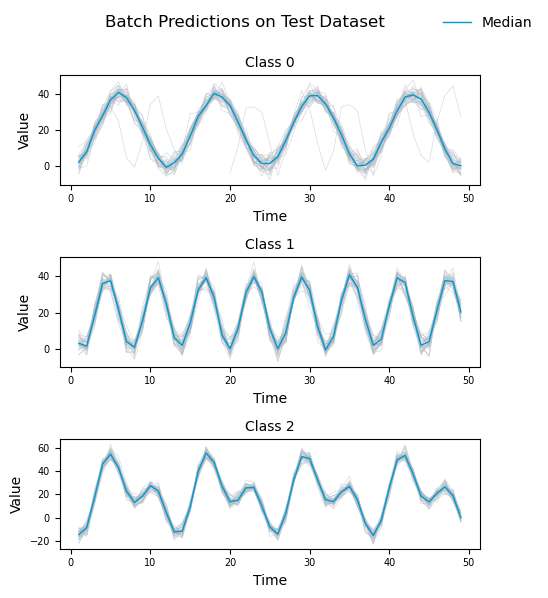

In [66]:
fig, axs = plt.subplots(nrows=batch_predictions.iloc[:, 0].nunique(), ncols=1, sharex=True, figsize=(5, 6))
for i, c in enumerate(batch_predictions.iloc[:, 0].sort_values().unique()):
    axs[i].plot(test_dataset[batch_predictions.iloc[:, 0] == c].iloc[:, 1:].transpose(), color="#AFB8C1", lw=0.5, alpha=0.5)
    axs[i].plot(test_dataset[batch_predictions.iloc[:, 0] == c].iloc[:, 1:].transpose().median(axis=1), color="#009ad3", lw=1, label="Median" if i == 0 else None)
    axs[i].set_title(f"Class {int(c)}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.subplots_adjust(hspace=0.75)
fig.suptitle("Batch Predictions on Test Dataset")
fig.legend(frameon=False, bbox_to_anchor=(0, 0, 1.1, 1))
fig.tight_layout()
fig.subplots_adjust(top=0.88)
fig.show()

In [67]:
np.all(batch_predictions.values == real_time_predictions.values)

True

In [68]:
batch_results = sagemaker_session.upload_string_as_file_body(
    body=batch_predictions.to_csv(index=False, header=False),
    bucket=bucket,
    key="data/inference/output/batch/batch_predictions.csv"
)

In [69]:
batch_results

's3://sagemaker-eu-west-1-661670223746/data/inference/output/batch/batch_predictions.csv'

## 7. Clean-up

### A. Delete the model

In [70]:
transformer.delete_model()

INFO:sagemaker:Deleting model with name: cnn-svc-algo-v1-1-2023-08-13-18-05-55-6-2023-08-13-18-06-41-117


### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the algorithm, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

